# 0. 영화 구분과 영화 장르 간에 내재된 편향성을 측정하기

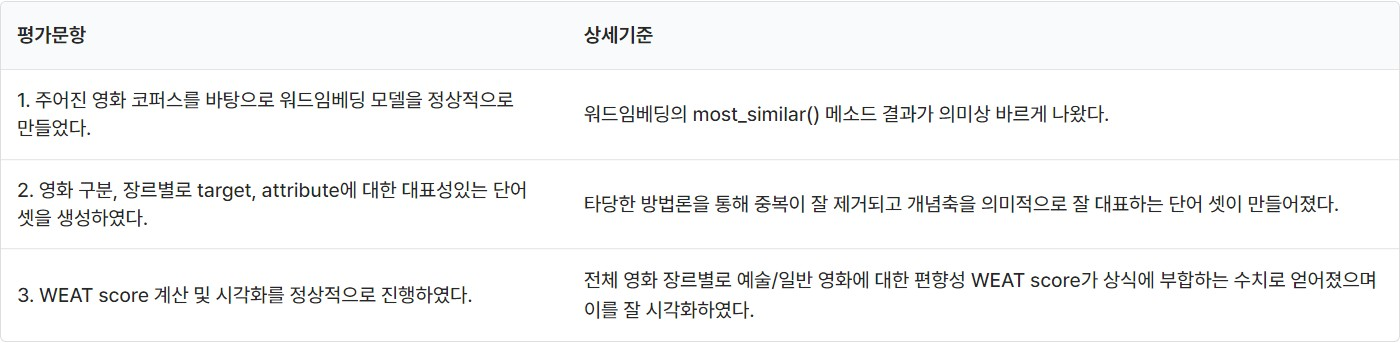

우리는 과연 인공지능을 온전히 믿을 수 있을까?  
챗봇과 대화하다 보면 가끔씩 편향된 대답을 내놓는 경우가 있다.  
데이터로부터 편향성이 생긴 경우다.  

그래서 오늘은 워드 임베딩에 숨어 있는 편향성을 측정하는 대표적인 방법론인 Word Embedding Association Test (WEAT) 라는 기법에 대해 알아보고, 이를 활용해 우리가 학습시킨 Word2Vec 임베딩 내의 편향성을 측정해 보면서 실제로 이 방법론이 우리 머리 속에 있는 편향성을 잘 반영하는지도 살펴보겠다.

WEAT(Word Embedding Association Test)의 예시

Male과 Female, Science와 Art라는 개념을 가장 잘 대표하는 단어들을 여러 개 골라 단어 셋(set)을 만든다.  
단어 셋에 속한 모든 단어들끼리의 편향성을 전부 계산해서 평균을 수치화해보면 보다 명확하게 개념적인 편향성이 존재함을 밝힐 수 있을 것이다.  
이러한 단어 셋을 WEAT에서는 각각 target 과 attribute 라고 한다.  
Science를 대표하는 target 단어 셋 X와 Art를 대표하는 target 단어 셋 Y가 있다고 하면 X-Y 셋을 통한 개념축 하나가 얻어진다.  
Male을 대표하는 attribute 단어 셋 A와 Female을 대표하는 attribute 단어 셋 B가 있다면 A-B 셋을 통한 개념축 하나가 또 얻어진다.  
편향성이 없다면, X에 속한 단어들은 A에 속한 단어들과의 거리와 B에 속한 단어들과의 거리가 별 차이가 없어야 한다.  
반대의 경우라면 뚜렷하게 차이가 날 것이다. Y의 경우도 마찬가지다.

다음 스텝에 수식을 통해 보다 명확하게 설명할 WEAT score는 바로 위와 같은 방식으로 계산된 수치다.  
절댓값이 클수록 두 개념축 사이의 편향성이 크게 나타나는 것으로 해석된다.

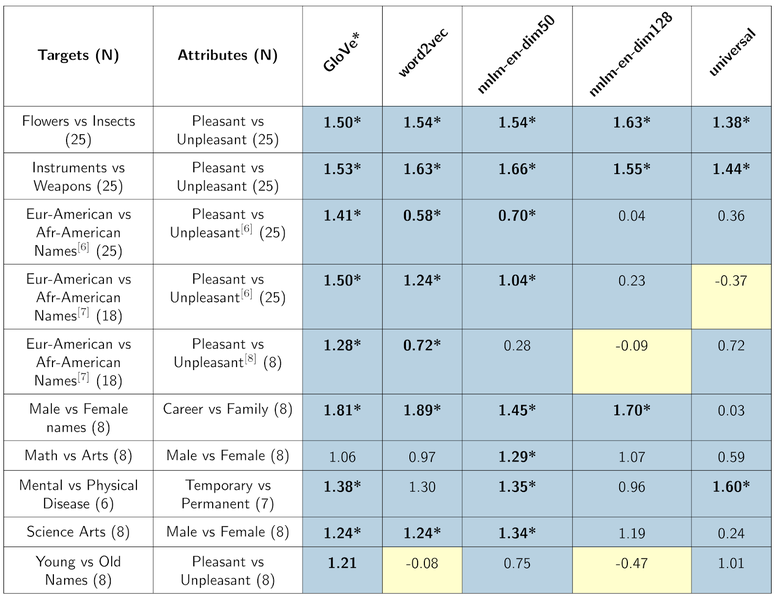

In [3]:
import os

from konlpy.tag import Okt

from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

from numpy import linalg

import matplotlib.pyplot as plt

import seaborn as sns

In [4]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

# 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

synopsis.txt(대략 17MB)에는 2001년부터 2019년 8월까지 제작된 영화들의 시놉시스 정보가 있다.

In [5]:
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(10):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.


이제 synopsis.txt 파일을 읽어 품사가 명사인 경우만 남겨 tokenized라는 변수명으로 저장해보자.  
konlpy 패키지를 이용하여 토크나이징한다.

In [6]:
okt = Okt()
tokenized = []

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.nouns(line) # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(words)

In [7]:
tokenized[: 10]

[['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분'],
 ['시절', '상처', '아버지', '박인환', '분', '고모', '신신애', '분', '살'],
 ['겨울', '그', '지방', '방송국', '라디오', '은수', '이영애', '분', '를'],
 ['자연', '소리', '채집', '라디오', '프로그램', '준비', '은수', '상우', '녹음', '여행'],
 ['두', '사람', '날', '은수', '아파트', '밤'],
 ['사랑', '두', '사람', '상우', '주체', '수', '정도', '그녀'],
 ['겨울', '만난', '두', '사람', '관계', '봄', '지나', '여름', '맞이', '삐걱', '거', '린다'],
 ['이혼', '경험', '은수', '상우', '결혼', '생각', '표정', '내비'],
 ['사랑', '상우', '은수', '단호', '말'],
 ['것', '사랑', '그', '사실', '상우', '어찌']]

In [8]:
print(len(tokenized))

71156


# 2. 추출된 결과로 embedding model 만들기

Word2Vec를 이용해서 임베딩 모델을 만든다.

In [9]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다.
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

most_similar를 이용하면 특정 단어와 가장 유사한 단어들을 알려준다.

In [10]:
model.wv.most_similar(positive=['영화'])

[('작품', 0.9002625942230225),
 ('다큐멘터리', 0.8501790761947632),
 ('드라마', 0.826490044593811),
 ('영화로', 0.8026109933853149),
 ('주제', 0.7860573530197144),
 ('코미디', 0.7745380401611328),
 ('감동', 0.7709289789199829),
 ('형식', 0.7680273056030273),
 ('소재', 0.7665576338768005),
 ('영상', 0.7664746642112732)]

In [11]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.7162890434265137),
 ('감정', 0.6939079761505127),
 ('만남', 0.6917250156402588),
 ('가슴', 0.6893616914749146),
 ('애정', 0.6813908219337463),
 ('진심', 0.6786919236183167),
 ('아르튬', 0.6758958101272583),
 ('고백', 0.6739800572395325),
 ('첫사랑', 0.6718659400939941),
 ('운명', 0.670981228351593)]

In [12]:
model.wv.most_similar(positive=['연극'])

[('영감', 0.8966485857963562),
 ('시나리오', 0.8944019079208374),
 ('영화감독', 0.8914307951927185),
 ('캐스팅', 0.8806396722793579),
 ('오페라', 0.871666431427002),
 ('각색', 0.8693745732307434),
 ('배우', 0.8662382960319519),
 ('대본', 0.8609899282455444),
 ('영화로', 0.8542418479919434),
 ('무용', 0.8525569438934326)]

의미상 바르게 나온 것을 확인할 수 있다.

# 3. target, attribute 단어 셋 만들기

WEAT score를 구할 때 단어 셋을 만들어주어야 한다.  
여기서는 두 축을 영화 구분, 영화 장르 정보를 이용하겠다.

영화 구분
- synopsis_art.txt : 예술영화
- synopsis_gen.txt : 일반영화(상업영화)

장르 구분
- synopsis_SF.txt: SF
- synopsis_가족.txt: 가족
- synopsis_공연.txt: 공연
- synopsis_공포(호러).txt: 공포(호러)
- synopsis_기타.txt: 기타
- synopsis_다큐멘터리.txt: 다큐멘터리
- synopsis_드라마.txt: 드라마
- synopsis_멜로로맨스.txt: 멜로로맨스
- synopsis_뮤지컬.txt: 뮤지컬
- synopsis_미스터리.txt: 미스터리
- synopsis_범죄.txt: 범죄
- synopsis_사극.txt: 사극
- synopsis_서부극(웨스턴).txt: 서부극(웨스턴)
- synopsis_성인물(에로).txt: 성인물(에로)
- synopsis_스릴러.txt: 스릴러
- synopsis_애니메이션.txt: 애니메이션
- synopsis_액션.txt: 액션
- synopsis_어드벤처.txt: 어드벤처
- synopsis_전쟁.txt: 전쟁
- synopsis_코미디.txt: 코미디
- synopsis_판타지.txt: 판타지

이번에는 예술영화와 일반영화(상업영화)라는 영화구분을 target으로 삼고, 드라마 장르와 액션 장르라는 장르구분을 attribute로 삼아 WEAT score를 계산해 보겠다.  
예를 들면 드라마 장르는 예술영화적 성격이 강하고, 액션 장르는 일반(상업)영화적 성격이 강할 것이라는 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지를 측정해 보겠다는 것이다.

'synopsis_art.txt', 'synopsis_gen.txt' 두 파일을 읽고, 위에서 했던 것과 마찬가지로 명사에 대해서만 추출하여 art, gen 변수에 할당하겠다.

In [13]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            words = okt.nouns(line) 
            result.extend(words)
    return ' '.join(result) # 여러 문장을 하나의 문장으로 통합

In [14]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [15]:
print(len(art))
print(art[: 100])

print(len(gen))
print(gen[: 100])

620226
사운드 엔지니어 상우 유지태 분 치매 할머니 백성희 분 시절 상처 아버지 박인환 분 고모 신신애 분 살 겨울 그 지방 방송국 라디오 은수 이영애 분 를 자연 소리 채집 라디오 프로
3014760
유사 연령 성별 빈부 차이 정치 입장 불문 국민 통합 온 애국심 성역 일침 다큐멘터리 재작년 전국 민족 민주 유가족 협의 회의 장기 농성 인상 다큐멘터리 민들레 를 독립영화 집단 


WEAT 계산을 위해서는 총 4개의 단어 셋 X, Y, A, B가 필요하다.  
이를 위해서 상식을 동원해서 적절한 단어를 골라낼 수도 있지만 보다 납득할 수 있는 보편적인 방법을 사용하는 것이 좋다.  

예술영화를 잘 대표하는 단어란 예술영화 시놉시스에는 자주 나타나지만 그 외 다른 구분의 영화(예를 들어 일반영화) 시놉시스에는 자주 나타나지 않는 것을 고르는 것이 적당할 것이다.  

이런 것과 비슷한 개념의 단어 분석 방식 중, TF-IDF라는 것이 있는데,  
코퍼스에서 자주 나타나는(TF가 높은) 단어이지만,  
다른 코퍼스에까지 두루 걸쳐 나오지는 않는(IDF가 높은) 단어를 선정하고 싶은 것이다.  
이번에는 단어 셋 구성을 위해 TF-IDF방식을 사용하겠다.

In [16]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

In [17]:
print(X.shape)
X

(2, 41098)


<2x41098 sparse matrix of type '<class 'numpy.float64'>'
	with 56731 stored elements in Compressed Sparse Row format>

In [18]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23986
영파


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [19]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')

for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')

for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

두 개념을 대표하는 단어를 TF-IDF가 높은 순으로 추출하고 싶었는데, 양쪽에 중복된 단어가 너무 많은 것을 볼 수 있다.  
두 개념축이 대조되도록 대표하는 단어 셋을 만들고 싶기 때문에 단어가 서로 중복되지 않게 단어셋을 추출해야 한다.  
우선 상위 100개의 단어들 중 중복되는 단어를 제외하고 상위 n(=15)개의 단어를 추출한다.

In [20]:
w1_, w2_ = [], []

for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

n = 15
target_art, target_gen = [], []
# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv):
        target_art.append(w1_[i])
        
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv):
        target_gen.append(w2_[i])
        
    if len(target_gen) == n: break

In [21]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [22]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


이번에는 장르별 대표 단어를 추출해 보자.

In [23]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [24]:
# 약 10분정도 걸립니다.
genre = []

for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [25]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42207)


In [26]:
m = [X[i].tocoo() for i in range(X.shape[0])]
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

In [27]:
w_ = []

for i in range(len(w)):
    ww_ = []
    for j in range(454):
        ww_.append(vectorizer.get_feature_names()[w[i][j][0]])
    w_.append(ww_)

In [28]:
for i in w_:
    print(len(i), end=', ')

454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 454, 

중복이 1번이라도 발생하면 전부 제거한다.

In [29]:
n = 10
attributes = []

for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    except_me = set()
    for k in range(len(w)):
        if k != i:
            except_me.update(w_[k])
    
    for j in range(len(w_[i])):
        if (w_[i][j] not in except_me) and (w_[i][j] in model.wv):
            attr.append(w_[i][j])
            print(w_[i][j], end=', ')
        if len(attr) == n: break 
    attributes.append(attr)
    print()

SF: 스타크, 리플리, 켈빈, 컨트, 수퍼맨, 분파, 물체, 진화, 수트, 히노키, 
가족: 아주르, 낙타, 씨제이, 동구, 슈이트, 마갈, 미아, 펠리칸, 벤트, 케이시, 
공연: 실황, 올레, 오텔로, 리골레토, 프레, 베르디, 비바, 콘서트, 백작부인, 반니, 
공포(호러): 악령, 분홍신, 캠핑, 정신병원, 레드, 에이미, 심령, 호러, 환영, 레스태트, 
기타: 뉴미디어, 메트로, 실험영화, 프라이드, 공사, 독도, 재연, 교통, 완섭, 사물, 
다큐멘터리: 투쟁, 인디다큐페스티발, 지난, 건축사, 세대, 공동체, 세월호, 산업, 교육, 이주, 
드라마: 의지, 하루하루, 교사, 주목, 
멜로로맨스: 미연, 펜션, 수진, 하숙집, 주희, 준석, 처제, 호감, 정식, 정우, 
뮤지컬: 에스메랄다, 충무로, 니웨, 바흐, 페뷔스, 프롤, 모도, 제루샤, 샤오캉, 데이비, 
미스터리: 방독면, 랭던, 몰카, 거미숲, 홈즈, 종섭, 한나, 승호, 동식, 민수현, 
범죄: 한길수, 파푸아, 금고, 마샨, 철중, 도미, 사기꾼, 맥베드, 와처스, 샤오창, 
사극: 신기전, 아가멤논, 루안, 하선, 윤서, 세자, 허균, 노준, 채선, 신재효, 
서부극(웨스턴): 벌린, 카우보이, 그레이프바인, 개릿, 무법자, 프린트, 마적, 태구, 버질, 랜던, 
성인물(에로): 유이, 성관계, 카즈야, 애무, 타케시, 타츠야, 토오루, 히로시, 사유리, 시오리, 
스릴러: 영훈, 감금, 혜영, 트래셔, 탤리, 명훈, 이하연, 성열, 콘로, 비숍, 
애니메이션: 인디애니페스트, 도롱, 퍼니퍼, 고고, 펭귄, 코리아, 임팩트, 곰퉁, 마트, 물고기, 
액션: 무술, 테러리스트, 암살자, 케인, 파이터, 패트레이버, 강호, 카이, 신분, 고용, 
어드벤처: 앤트, 옥자, 원주민, 윈치, 펠레, 크루소, 양말, 루카스, 썰매개, 루거, 
전쟁: 윈터스, 연합군, 미군, 나치, 병사, 이지중대, 혁리, 중위, 동막골, 전장, 
코미디: 삼순, 게다가, 진헌, 퍼프, 티탕, 절친, 좌충

의미적으로 잘 대표하는 단어 셋이 만들어졌다.

# 4. WEAT score 계산과 시각화

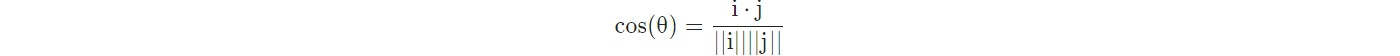

In [30]:
def cos_sim(i, j):
    return np.dot(i, j.T) / (linalg.norm(i) * linalg.norm(j))

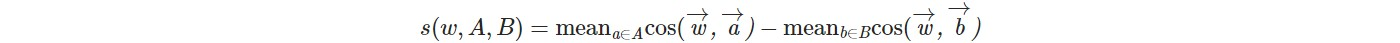

In [31]:
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

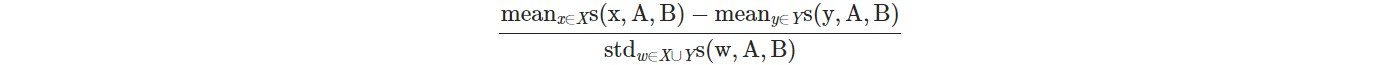

In [32]:
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X - mean_Y) / std_dev

위 식의 분자 부분은 target X, Y에 속하는 각 단어 x, y들이 개념축 A-B에 대해 가지는 편향성을 각각 평균 내서 뺀 차이다.  
즉, X에 속하는 단어들과 Y에 속하는 단어들이 A-B 개념축에 대해 가지는 편향성의 정도가 뚜렷이 차이 날수록 이 WEAT score 식의 분자값의 절댓값은 커지게 된다.  
이 값을 X, Y에 속하는 모든 단어들이 가지는 편향성 값의 표준편차(std)로 normalize한 값이 최종 WEAT score가 된다.

이제 WEAT_score를 구해보자.  
예를 들어 traget_X는 art, target_Y는 gen, attribute_A는 '드라마', attribute_B는 '액션' 과 같이 정해줄 수 있다.  
target_X 는 art, target_Y 는 gen으로 고정하고 attribute_A, attribute_B를 바꿔가면서 구한 후  
결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담는다.

In [33]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [34]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [35]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j], matrix[i][j])

SF 가족 -1.0013478
SF 공연 -0.203165
SF 공포(호러) -1.0641333
SF 기타 0.57257235
SF 다큐멘터리 0.5256133
SF 드라마 -0.67909753
SF 멜로로맨스 -0.95743185
SF 뮤지컬 0.042697433
SF 미스터리 -1.0272791
SF 범죄 -0.4872864
SF 사극 -0.95887387
SF 서부극(웨스턴) -0.41942522
SF 성인물(에로) -0.8390456
SF 스릴러 -0.8376606
SF 애니메이션 -0.72913486
SF 액션 -0.43653658
SF 어드벤처 -0.8408604
SF 전쟁 0.17270194
SF 코미디 -1.0117272
SF 판타지 -1.1555513
가족 공연 0.94991446
가족 공포(호러) 0.35624695
가족 기타 1.0946195
가족 다큐멘터리 0.8715858
가족 드라마 0.3122006
가족 멜로로맨스 -0.6789724
가족 뮤지컬 0.98307085
가족 미스터리 0.21082452
가족 범죄 1.0969865
가족 사극 0.90461904
가족 서부극(웨스턴) 1.1319004
가족 성인물(에로) -0.42008898
가족 스릴러 0.115373194
가족 애니메이션 0.8673248
가족 액션 0.89390653
가족 어드벤처 1.0079639
가족 전쟁 1.0704381
가족 코미디 0.10891611
가족 판타지 0.6195417
공연 공포(호러) -0.704019
공연 기타 1.02211
공연 다큐멘터리 0.6346904
공연 드라마 -0.5758275
공연 멜로로맨스 -0.93970174
공연 뮤지컬 0.6148525
공연 미스터리 -0.7975179
공연 범죄 -0.28686103
공연 사극 -0.5240159
공연 서부극(웨스턴) -0.26383486
공연 성인물(에로) -0.76821303
공연 스릴러 -0.6294256
공연 애니메이션 -0.5428388
공연 액션 -0.23932584
공연 어드벤처

<AxesSubplot:>

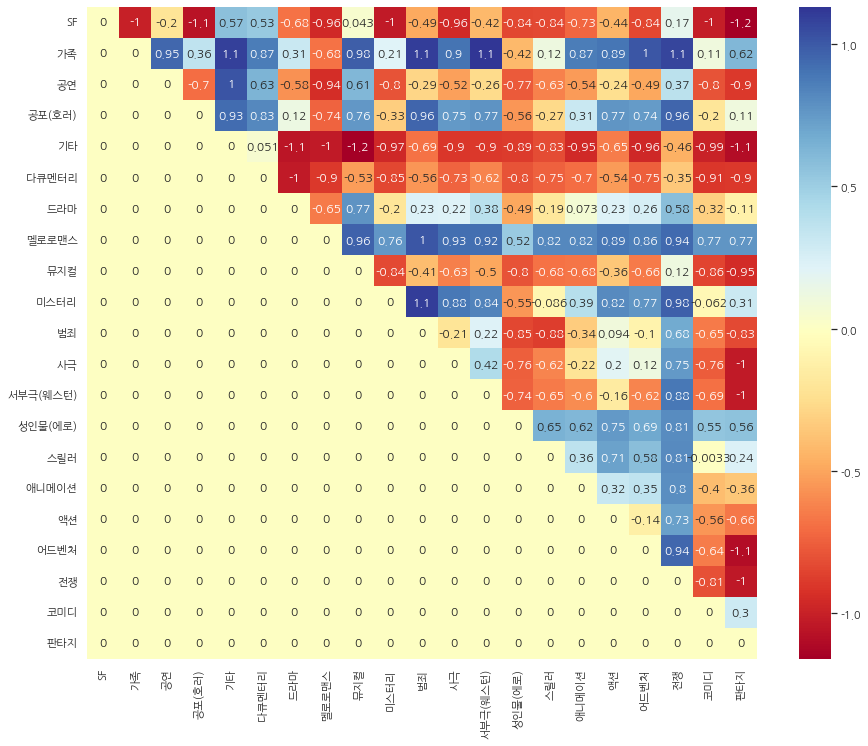

In [38]:
plt.figure(figsize=(15, 12))
sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, cmap='RdYlBu')


행은 attribute_A, 열은 attribute_B이고,  
값이 양수가 나오면 attribute_A ≒ target_X, attribute_B ≒ target_Y  
라는 뜻이고 음수가 나오면 반대로  
attribute_A ≒ target_Y, attribute_B ≒ target_X  
라는 뜻이다.(여기서 ≒는 가깝다는 뜻으로 사용함.)  
target_X == 예술영화, target_Y == 일반영화라는 것을 명심하자.  
순서가 바뀌면 부호가 바뀌어서 해석이 정반대가 되버린다.

가장 편향성이 두드러지는 멜로로맨스 attribute를 살펴보자.  
attribute_A가 멜로로맨스인 모든 상황에서 값이 양수이고,  
attribute_B가 멜로로맨스인 모든 상황에서 값이 음수인 것을 보면,  
멜로로맨스는 예술영화에 매우 가깝다는 것을 알 수 있다.

# 5. 회고하기

뭔가 뜬금없이 Word Embedding Association에 대해서 배우고  
편향성을 측정하긴 했는데 그 다음에 뭘 하라는 건지,  
편향이 있으면 좋은 건지 나쁜 건지,  
편향을 어떻게 수정해야 하는 건지도 모르겠다.  
아마 상황에 따라 편향이 존재하는 게 좋을 때도 있고 안좋을 때도 있는 것 같은데  
이번 프로젝트 같은 상황에서는 편향이 존재하는 게 더 자연스러운 것 같다.  
그래도 임베딩과 간단한 공식을 이용해서 편향을 측정할 수 있다는 것이 신기했다.